In [89]:
import os
import subprocess

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from tqdm.auto import tqdm

from radmc3dPy.image import readImage, plotImage, makeImage
from astropy import constants as c

au = c.au.cgs.value
pc = c.pc.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value
Grav = c.G.cgs.value
m_p = c.m_p.cgs.value


def logistic(a, r, r0, dr):
    return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


def grid_refine_inner_edge(x_orig, nlev, nspan):
    x = x_orig.copy()
    rev = x[0] > x[1]
    for ilev in range(nlev):
        x_new = 0.5 * (x[1:nspan + 1] + x[:nspan])
        x_ref = np.hstack((x, x_new))
        x_ref.sort()
        x = x_ref
        if rev:
            x = x[::-1]
    return x


def warp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) - y * np.sin(phi) * np.cos(theta) + z * np.sin(phi) * np.sin(theta)
    yprime = x * np.sin(phi) + y * np.cos(phi) * np.cos(theta) - z * np.sin(theta) * np.cos(phi)
    zprime = y * np.sin(theta) + z * np.cos(theta)
    return xprime, yprime, zprime


def unwarp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) + y * np.sin(phi)
    yprime = -x * np.sin(phi) * np.cos(theta) + y * np.cos(phi) * np.cos(theta) + z * np.sin(theta)
    zprime = x * np.sin(phi) * np.sin(theta) - y * np.sin(theta) * np.cos(phi) + z * np.cos(theta)
    return xprime, yprime, zprime

def vel_sph_to_car(theta, phi, vr, vtheta, vphi):
    
    vx = vr*np.sin(theta)*np.cos(phi) + vtheta*np.cos(phi)*np.cos(theta) - vphi*np.sin(phi) 
    vy = vr*np.sin(phi)*np.sin(theta) + vtheta*np.sin(phi)*np.cos(theta) + vphi*np.cos(phi)
    vz = vr*np.cos(theta) - vtheta*np.sin(theta)
    #print(vx, vy, vz)
    
    return vx, vy, vz

def vel_car_to_sph(theta, phi, vx, vy, vz):
    
    vr = vx*np.sin(theta)*np.cos(phi) + vy*np.sin(theta)*np.sin(phi) + vz*np.cos(theta)
    vt = vx*np.cos(theta)*np.cos(phi) + vy*np.cos(theta)*np.sin(phi) - vz*np.sin(theta)
    vp = -vx*np.sin(phi) + vy*np.cos(phi)
    
    return vr, vt, vp

In [2]:
def call_radmc(cmd, verbose=False, total=None):
    """
    Run radmc3d command and show progress bar instead.
    
    cmd : str
        the command to run, e.g. 'radmc3d mctherm'
        
    verbose : bool
        if True, then all output except the photon packges are shown
        if False, just the progress is shown.
        
    total : None | int
        total number of photon packages, if known
    """
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output = []
    
    if 'nphot' in cmd:
        total = int(cmd.split('nphot')[1].split()[1])

    with tqdm(total=total, unit='photons') as pbar:
        for line in p.stdout:
            if 'Photon nr' in line:
                pbar.update(1000)
            elif verbose:
                print(line, end='')
            output += [line]
    rc = p.wait()
    return rc, ''.join(output)

In [3]:
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat = 1000000

In [4]:
# Grid parameters
#
n_r = 200
n_theta = 128
n_phi = 256
r_in = 0.5 * au
r_out = 100 * au
thetaup = 0.1       # Theta grid starting point (0=pole, but singular, so choose >0)

In [5]:
# inner edge grid refinement
nlev_rin = 8
nspan_rin = 3

In [6]:
# Disk parameters
#
sigma_0 = 1e1           # Gas surface density at 1 au [g / cm^2]
d2g = 0.01              # dust-to-gas ratio
gamma_gas = 1.0         # power-law exponent of the surface density
hor_0 = 0.05            # h/r at 1 au
hor_exp = 0.1           # flaring exponent

In [7]:
# Star parameters
#
M_star = 2.4 * M_sun
R_star = 2.4 * R_sun
T_star = 1e4
star_coord = np.array([0., 0., 0.])

In [8]:
# Make the coordinates
#
ri = np.geomspace(r_in, r_out, n_r + 1)
ri = grid_refine_inner_edge(ri, nlev_rin, nspan_rin)   # Refinement at inner edge
thetai = np.linspace(thetaup, np.pi - thetaup, n_theta + 1)
phii = np.linspace(0.0, 2.0 * np.pi, n_phi + 1)
rc = 0.5 * (ri[:-1] + ri[1:])
thetac = 0.5 * (thetai[:-1] + thetai[1:])
phic = 0.5 * (phii[:-1] + phii[1:])
n_r = len(rc)     # Recompute nr, because of refinement at inner edge

In [9]:
# Make the full mesh
#
RC, THETAC, PHIC = np.meshgrid(rc, thetac, phic, indexing='ij')
XC = RC * np.sin(THETAC) * np.cos(PHIC)
YC = RC * np.sin(THETAC) * np.sin(PHIC)
ZC = RC * np.cos(THETAC)

### Make the warped model

In [10]:
# un-warp the coordinates
#
warp = 30. # PA
twist = 45. # This gives the inc

warp_array = logistic(warp, rc, 40 * au, 20 * au)  # Specify the r0 and dr in AU
twist_array = logistic(twist, rc, 40 * au, 20 * au)

XU, YU, ZU = unwarp_coordinates(
    XC, YC, ZC,
    warp_array[:, None, None],
    twist_array[:, None, None])

RU = np.sqrt(XU**2 + YU**2 + ZU**2)
THETAU = np.pi / 2.0 - np.arctan2(ZU, np.sqrt(XU**2 + YU**2))
PHIU = (np.arctan2(YU, XU) + np.pi)%(2 * np.pi)
#print(PHIU.max(), PHIU.min())
#print(THETAU.max(), THETAU.min())

In [11]:
# Make the dust density model
#
sig_g = sigma_0 * (RU / au)**-gamma_gas
H = hor_0 * (RU / au)**hor_exp * RU
rho_g = (sig_g / (np.sqrt(2. * np.pi) * H)) * np.exp(-(ZU**2 / H**2) / 2.0)
rho_d = d2g * rho_g

In [12]:
# Make the gas temperature model
T_0 = 300.
q = 0.5
tgas = T_0 * (RU / (50.0 * au))**(-q)

In [13]:
#XU, YU, ZU = unwarp_coordinates(XW, YW, ZW, warp_array[:, None, None], twist_array[:, None, None])
VRU = np.zeros_like(RU)
VTU = np.zeros_like(RU)
VPU = np.sqrt(Grav * M_star / RU)

# make cartesian velocities

VXU, VYU, VZU = vel_sph_to_car(THETAU, PHIU, VRU, VTU, VPU)

# warp velocities
VXW, VYW, VZW = warp_coordinates(
    VXU, VYU, VZU,
    warp_array[:, None, None],
    twist_array[:, None, None])

# obtain velocities in spherical from the original mesh
VRW, VTW, VPW = vel_car_to_sph(THETAC, PHIC, VXU, VYU, VZU)

vturb = 0.001 * VPW

### Write RADMC3D SETUP

In [14]:
# Write the wavelength_micron.inp file
#
lam1 = 0.1e0
lam2 = 7.0e0
lam3 = 25.0e0
lam4 = 1.0e4
n12 = 20
n23 = 100
n34 = 30
lam12 = np.geomspace(lam1, lam2, n12, endpoint=False)
lam23 = np.geomspace(lam2, lam3, n23, endpoint=False)
lam34 = np.geomspace(lam3, lam4, n34, endpoint=True)
lam = np.concatenate([lam12, lam23, lam34])
nlam = lam.size

In [15]:
# Write the wavelength file
#
with open('wavelength_micron.inp', 'w+') as f:
    f.write('%d\n' % (nlam))
    for value in lam:
        f.write('%13.6e\n' % (value))

In [16]:
# Write the stars.inp file
#
with open('stars.inp', 'w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n' % (nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n' % (R_star, M_star, *star_coord))
    for value in lam:
        f.write('%13.6e\n' % (value))
    f.write('\n%13.6e\n' % (-T_star))

In [17]:
# Write the grid file
#
with open('amr_grid.inp', 'w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 1\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n' % (n_r, n_theta, n_phi))  # Size of grid
    for value in ri:
        f.write('%13.6e\n' % (value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n' % (value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n' % (value))      # Z coordinates (cell walls)

In [18]:
# Write the density file
#
with open('dust_density.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rho_d.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [19]:
# Dust opacity control file
#
with open('dustopac.inp', 'w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')

In [20]:
# Write the molecule number density file.
#
CO_abundance = 1e-4
fact_CO = CO_abundance / (2.3 * m_p)
nco = rho_g * fact_CO
with open('numberdens_co.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [21]:
# Write the gas velocity field
#
with open('gas_velocity.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    for iphi in range(n_phi):
        for itheta in range(n_theta):
            for ir in range(n_r):
                f.write('%13.6e %13.6e %13.6e\n' % (VRW[ir, itheta, iphi], VTW[ir, itheta, iphi], VPW[ir, itheta, iphi]))

In [22]:
# Write the microturbulence file
#
with open('microturbulence.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [23]:
# Write the gas temperature file
#
with open('gas_temperature.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(n_r*n_theta*n_phi))           # Nr of cells
    data = tgas.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [24]:
# Write the lines.inp control file
#
with open('lines.inp', 'w') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')

In [25]:
# Write the radmc3d.inp control file
#
with open('radmc3d.inp', 'w+') as f:
    f.write('nphot = %d\n' % (nphot_therm))
    f.write('nphot_scat = %d\n' % (nphot_scat))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')
    f.write('tgas_eq_tdust = 0\n')

## Run RADMC-3D

In [122]:
dpc         = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)
incl        = 10.
phi         = 45.
npix        = 200
sizeau      = 200
lamda_image = 1.3e3

### Thermal Monte Carlo

In [123]:
rc, output = call_radmc('radmc3d mctherm setthreads 4', total=nphot_therm)
#os.system('radmc3d mctherm setthreads 4')

  0%|          | 0/1000000 [00:00<?, ?photons/s]

### Check density contours of dust and gas

In [124]:
import matplotlib.pylab as plb
from radmc3dPy import analyze, natconst

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


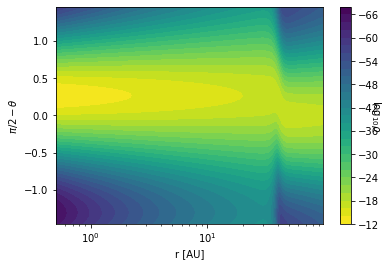

In [125]:
data = analyze.readData(ddens=True, ispec='co')
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, np.log10(data.rhodust[:,:,32,0].T), 30)
plb.xlabel('r [AU]')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')

cb = plb.colorbar(c)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)



In [126]:
# Now let's make a set of channel maps
vkms = 0.
rc, output = call_radmc(f'radmc3d image imolspec 1 iline 2 vkms {vkms} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau}', total=nphot_scat)
#os.system(f'radmc3d image imolspec 1 iline 2 vkms {vkms} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau}')

  0%|          | 0/1000000 [00:00<?, ?photons/s]

Read and plot the image

Reading image.out


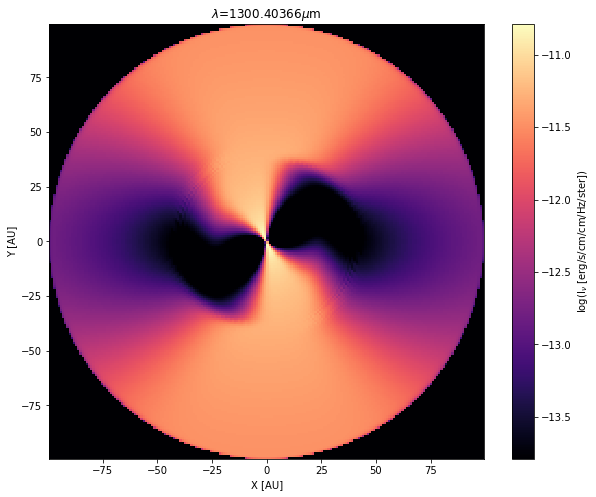

{'implot': <matplotlib.image.AxesImage at 0x7f34996ab580>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f3498fe6490>}

In [127]:
im = readImage()
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im, au=True, log=True, maxlog=3, bunit='inu', dpc=dpc, cmap='magma', ax=ax)

(-100.0, 100.0)

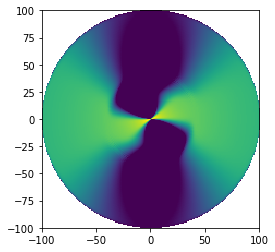

In [128]:
f, ax = plt.subplots()
vmax = im.image.max()
ax.imshow(im.image[:,:,0], norm=LogNorm(vmin=1e-2 * vmax, vmax=vmax), interpolation='none', extent=np.array([-r_out, r_out, -r_out, r_out])/au)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)

### Try to make momentmaps

In [129]:
# Create channelmaps in a range of +- 5km/s'
widthkms = 3
linenlam = 10
os.system(f'radmc3d image iline 2 widthkms {widthkms} linenlam {linenlam} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau} nphot_spec {nphot_scat}')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

 Thread:           3 Photon nr:                84000
 Thread:           3 Photon nr:                85000
 Thread:           2 Photon nr:                86000
 Thread:           3 Photon nr:                87000
 Thread:           1 Photon nr:                88000
 Thread:           3 Photon nr:                89000
 Thread:           3 Photon nr:                90000
 Thread:           0 Photon nr:                91000
 Thread:           0 Photon nr:                92000
 Thread:           3 Photon nr:                93000
 Thread:           1 Photon nr:                94000
 Thread:           1 Photon nr:                95000
 Thread:           1 Photon nr:                96000
 Thread:           1 Photon nr:                97000
 Thread:           1 Photon nr:                98000
 Thread:           1 Photon nr:                99000
 Thread:           1 Photon nr:               100000
 Thread:           3 Photon nr:               101000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               241000
 Thread:           0 Photon nr:               242000
 Thread:           1 Photon nr:               243000
 Thread:           2 Photon nr:               244000
 Thread:           1 Photon nr:               245000
 Thread:           2 Photon nr:               246000
 Thread:           2 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           3 Photon nr:               249000
 Thread:           0 Photon nr:               250000
 Thread:           3 Photon nr:               251000
 Thread:           3 Photon nr:               252000
 Thread:           2 Photon nr:               253000
 Thread:           0 Photon nr:               254000
 Thread:           3 Photon nr:               255000
 Thread:           2 Photon nr:               256000
 Thread:           1 Photon nr:               257000
 Thread:           3 Photon nr:               258000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               397000
 Thread:           2 Photon nr:               398000
 Thread:           3 Photon nr:               399000
 Thread:           3 Photon nr:               400000
 Thread:           2 Photon nr:               401000
 Thread:           2 Photon nr:               402000
 Thread:           0 Photon nr:               403000
 Thread:           0 Photon nr:               404000
 Thread:           2 Photon nr:               405000
 Thread:           1 Photon nr:               406000
 Thread:           2 Photon nr:               407000
 Thread:           2 Photon nr:               408000
 Thread:           3 Photon nr:               409000
 Thread:           2 Photon nr:               410000
 Thread:           1 Photon nr:               411000
 Thread:           1 Photon nr:               412000
 Thread:           3 Photon nr:               413000
 Thread:           0 Photon nr:               414000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               554000
 Thread:           0 Photon nr:               555000
 Thread:           1 Photon nr:               556000
 Thread:           3 Photon nr:               557000
 Thread:           3 Photon nr:               558000
 Thread:           1 Photon nr:               559000
 Thread:           2 Photon nr:               560000
 Thread:           1 Photon nr:               561000
 Thread:           1 Photon nr:               562000
 Thread:           2 Photon nr:               563000
 Thread:           0 Photon nr:               564000
 Thread:           2 Photon nr:               565000
 Thread:           0 Photon nr:               566000
 Thread:           0 Photon nr:               567000
 Thread:           1 Photon nr:               568000
 Thread:           3 Photon nr:               569000
 Thread:           0 Photon nr:               570000
 Thread:           3 Photon nr:               571000
 Thread:           3 Photon nr:               

 Thread:           2 Photon nr:               709000
 Thread:           1 Photon nr:               710000
 Thread:           3 Photon nr:               711000
 Thread:           3 Photon nr:               712000
 Thread:           3 Photon nr:               713000
 Thread:           3 Photon nr:               714000
 Thread:           3 Photon nr:               715000
 Thread:           1 Photon nr:               716000
 Thread:           1 Photon nr:               717000
 Thread:           1 Photon nr:               718000
 Thread:           2 Photon nr:               719000
 Thread:           3 Photon nr:               720000
 Thread:           1 Photon nr:               721000
 Thread:           2 Photon nr:               722000
 Thread:           2 Photon nr:               723000
 Thread:           0 Photon nr:               724000
 Thread:           2 Photon nr:               725000
 Thread:           2 Photon nr:               726000
 Thread:           3 Photon nr:               

 Thread:           0 Photon nr:               869000
 Thread:           2 Photon nr:               870000
 Thread:           0 Photon nr:               871000
 Thread:           2 Photon nr:               872000
 Thread:           1 Photon nr:               873000
 Thread:           2 Photon nr:               874000
 Thread:           1 Photon nr:               875000
 Thread:           3 Photon nr:               876000
 Thread:           1 Photon nr:               877000
 Thread:           2 Photon nr:               878000
 Thread:           1 Photon nr:               879000
 Thread:           0 Photon nr:               880000
 Thread:           3 Photon nr:               881000
 Thread:           1 Photon nr:               882000
 Thread:           0 Photon nr:               883000
 Thread:           0 Photon nr:               884000
 Thread:           2 Photon nr:               885000
 Thread:           2 Photon nr:               886000
 Thread:           2 Photon nr:               

 Thread:           2 Photon nr:                 6000
 Thread:           0 Photon nr:                 7000
 Thread:           1 Photon nr:                 8000
 Thread:           2 Photon nr:                 9000
 Thread:           1 Photon nr:                10000
 Thread:           2 Photon nr:                11000
 Thread:           3 Photon nr:                12000
 Thread:           1 Photon nr:                13000
 Thread:           0 Photon nr:                14000
 Thread:           3 Photon nr:                15000
 Thread:           0 Photon nr:                16000
 Thread:           3 Photon nr:                17000
 Thread:           3 Photon nr:                18000
 Thread:           3 Photon nr:                19000
 Thread:           1 Photon nr:                20000
 Thread:           0 Photon nr:                21000
 Thread:           3 Photon nr:                22000
 Thread:           2 Photon nr:                23000
 Thread:           1 Photon nr:               

 Thread:           0 Photon nr:               162000
 Thread:           2 Photon nr:               163000
 Thread:           1 Photon nr:               164000
 Thread:           1 Photon nr:               165000
 Thread:           1 Photon nr:               166000
 Thread:           1 Photon nr:               167000
 Thread:           3 Photon nr:               168000
 Thread:           1 Photon nr:               169000
 Thread:           3 Photon nr:               170000
 Thread:           3 Photon nr:               171000
 Thread:           3 Photon nr:               172000
 Thread:           3 Photon nr:               173000
 Thread:           3 Photon nr:               174000
 Thread:           0 Photon nr:               175000
 Thread:           3 Photon nr:               176000
 Thread:           0 Photon nr:               177000
 Thread:           0 Photon nr:               178000
 Thread:           2 Photon nr:               179000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               317000
 Thread:           1 Photon nr:               318000
 Thread:           3 Photon nr:               319000
 Thread:           2 Photon nr:               320000
 Thread:           0 Photon nr:               321000
 Thread:           0 Photon nr:               322000
 Thread:           3 Photon nr:               323000
 Thread:           3 Photon nr:               324000
 Thread:           2 Photon nr:               325000
 Thread:           1 Photon nr:               326000
 Thread:           0 Photon nr:               327000
 Thread:           3 Photon nr:               328000
 Thread:           3 Photon nr:               329000
 Thread:           3 Photon nr:               330000
 Thread:           0 Photon nr:               331000
 Thread:           1 Photon nr:               332000
 Thread:           0 Photon nr:               333000
 Thread:           0 Photon nr:               334000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               474000
 Thread:           1 Photon nr:               475000
 Thread:           3 Photon nr:               476000
 Thread:           2 Photon nr:               477000
 Thread:           0 Photon nr:               478000
 Thread:           1 Photon nr:               479000
 Thread:           3 Photon nr:               480000
 Thread:           0 Photon nr:               481000
 Thread:           3 Photon nr:               482000
 Thread:           2 Photon nr:               483000
 Thread:           3 Photon nr:               484000
 Thread:           1 Photon nr:               485000
 Thread:           1 Photon nr:               486000
 Thread:           1 Photon nr:               487000
 Thread:           1 Photon nr:               488000
 Thread:           1 Photon nr:               489000
 Thread:           2 Photon nr:               490000
 Thread:           1 Photon nr:               491000
 Thread:           3 Photon nr:               

 Thread:           1 Photon nr:               631000
 Thread:           1 Photon nr:               632000
 Thread:           1 Photon nr:               633000
 Thread:           2 Photon nr:               634000
 Thread:           2 Photon nr:               635000
 Thread:           1 Photon nr:               636000
 Thread:           2 Photon nr:               637000
 Thread:           2 Photon nr:               638000
 Thread:           0 Photon nr:               639000
 Thread:           1 Photon nr:               640000
 Thread:           3 Photon nr:               641000
 Thread:           1 Photon nr:               642000
 Thread:           1 Photon nr:               643000
 Thread:           3 Photon nr:               644000
 Thread:           3 Photon nr:               645000
 Thread:           0 Photon nr:               646000
 Thread:           0 Photon nr:               647000
 Thread:           0 Photon nr:               648000
 Thread:           0 Photon nr:               

 Thread:           2 Photon nr:               790000
 Thread:           0 Photon nr:               791000
 Thread:           0 Photon nr:               792000
 Thread:           0 Photon nr:               793000
 Thread:           1 Photon nr:               794000
 Thread:           0 Photon nr:               795000
 Thread:           1 Photon nr:               796000
 Thread:           3 Photon nr:               797000
 Thread:           2 Photon nr:               798000
 Thread:           1 Photon nr:               799000
 Thread:           3 Photon nr:               800000
 Thread:           1 Photon nr:               801000
 Thread:           2 Photon nr:               802000
 Thread:           3 Photon nr:               803000
 Thread:           3 Photon nr:               804000
 Thread:           1 Photon nr:               805000
 Thread:           0 Photon nr:               806000
 Thread:           3 Photon nr:               807000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               949000
 Thread:           0 Photon nr:               950000
 Thread:           2 Photon nr:               951000
 Thread:           1 Photon nr:               952000
 Thread:           3 Photon nr:               953000
 Thread:           1 Photon nr:               954000
 Thread:           3 Photon nr:               955000
 Thread:           1 Photon nr:               956000
 Thread:           3 Photon nr:               957000
 Thread:           2 Photon nr:               958000
 Thread:           3 Photon nr:               959000
 Thread:           2 Photon nr:               960000
 Thread:           1 Photon nr:               961000
 Thread:           3 Photon nr:               962000
 Thread:           0 Photon nr:               963000
 Thread:           2 Photon nr:               964000
 Thread:           1 Photon nr:               965000
 Thread:           0 Photon nr:               966000
 Thread:           3 Photon nr:               

 Thread:           0 Photon nr:                83000
 Thread:           1 Photon nr:                84000
 Thread:           2 Photon nr:                85000
 Thread:           2 Photon nr:                86000
 Thread:           1 Photon nr:                87000
 Thread:           1 Photon nr:                88000
 Thread:           0 Photon nr:                89000
 Thread:           2 Photon nr:                90000
 Thread:           2 Photon nr:                91000
 Thread:           0 Photon nr:                92000
 Thread:           2 Photon nr:                93000
 Thread:           3 Photon nr:                94000
 Thread:           2 Photon nr:                95000
 Thread:           2 Photon nr:                96000
 Thread:           2 Photon nr:                97000
 Thread:           3 Photon nr:                98000
 Thread:           2 Photon nr:                99000
 Thread:           3 Photon nr:               100000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               242000
 Thread:           2 Photon nr:               243000
 Thread:           3 Photon nr:               244000
 Thread:           1 Photon nr:               245000
 Thread:           1 Photon nr:               246000
 Thread:           1 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           3 Photon nr:               249000
 Thread:           0 Photon nr:               250000
 Thread:           3 Photon nr:               251000
 Thread:           3 Photon nr:               252000
 Thread:           0 Photon nr:               253000
 Thread:           3 Photon nr:               254000
 Thread:           1 Photon nr:               255000
 Thread:           1 Photon nr:               256000
 Thread:           3 Photon nr:               257000
 Thread:           0 Photon nr:               258000
 Thread:           1 Photon nr:               259000
 Thread:           3 Photon nr:               

 Thread:           2 Photon nr:               397000
 Thread:           3 Photon nr:               398000
 Thread:           3 Photon nr:               399000
 Thread:           0 Photon nr:               400000
 Thread:           0 Photon nr:               401000
 Thread:           1 Photon nr:               402000
 Thread:           2 Photon nr:               403000
 Thread:           2 Photon nr:               404000
 Thread:           0 Photon nr:               405000
 Thread:           2 Photon nr:               406000
 Thread:           0 Photon nr:               407000
 Thread:           1 Photon nr:               408000
 Thread:           0 Photon nr:               409000
 Thread:           0 Photon nr:               410000
 Thread:           3 Photon nr:               411000
 Thread:           1 Photon nr:               412000
 Thread:           2 Photon nr:               413000
 Thread:           0 Photon nr:               414000
 Thread:           2 Photon nr:               

 Thread:           2 Photon nr:               553000
 Thread:           0 Photon nr:               554000
 Thread:           2 Photon nr:               555000
 Thread:           0 Photon nr:               556000
 Thread:           0 Photon nr:               557000
 Thread:           3 Photon nr:               558000
 Thread:           2 Photon nr:               559000
 Thread:           2 Photon nr:               560000
 Thread:           3 Photon nr:               561000
 Thread:           1 Photon nr:               562000
 Thread:           2 Photon nr:               563000
 Thread:           0 Photon nr:               564000
 Thread:           3 Photon nr:               565000
 Thread:           2 Photon nr:               566000
 Thread:           2 Photon nr:               567000
 Thread:           0 Photon nr:               568000
 Thread:           1 Photon nr:               569000
 Thread:           0 Photon nr:               570000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               709000
 Thread:           2 Photon nr:               710000
 Thread:           3 Photon nr:               711000
 Thread:           2 Photon nr:               712000
 Thread:           3 Photon nr:               713000
 Thread:           3 Photon nr:               714000
 Thread:           1 Photon nr:               715000
 Thread:           0 Photon nr:               716000
 Thread:           2 Photon nr:               717000
 Thread:           0 Photon nr:               718000
 Thread:           2 Photon nr:               719000
 Thread:           2 Photon nr:               720000
 Thread:           2 Photon nr:               721000
 Thread:           0 Photon nr:               722000
 Thread:           0 Photon nr:               723000
 Thread:           3 Photon nr:               724000
 Thread:           1 Photon nr:               725000
 Thread:           3 Photon nr:               726000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               864000
 Thread:           1 Photon nr:               865000
 Thread:           2 Photon nr:               866000
 Thread:           2 Photon nr:               867000
 Thread:           2 Photon nr:               868000
 Thread:           1 Photon nr:               869000
 Thread:           1 Photon nr:               870000
 Thread:           3 Photon nr:               871000
 Thread:           1 Photon nr:               872000
 Thread:           0 Photon nr:               873000
 Thread:           0 Photon nr:               874000
 Thread:           3 Photon nr:               875000
 Thread:           1 Photon nr:               876000
 Thread:           3 Photon nr:               877000
 Thread:           2 Photon nr:               878000
 Thread:           3 Photon nr:               879000
 Thread:           2 Photon nr:               880000
 Thread:           1 Photon nr:               881000
 Thread:           1 Photon nr:               

 Thread Nr           1 of           4 threads in total
 Thread Nr           3 of           4 threads in total
 Thread Nr           0 of           4 threads in total
 Thread Nr           2 of           4 threads in total
 Thread:           2 Photon nr:                 1000
 Thread:           2 Photon nr:                 2000
 Thread:           0 Photon nr:                 3000
 Thread:           2 Photon nr:                 4000
 Thread:           1 Photon nr:                 5000
 Thread:           1 Photon nr:                 6000
 Thread:           2 Photon nr:                 7000
 Thread:           1 Photon nr:                 8000
 Thread:           2 Photon nr:                 9000
 Thread:           2 Photon nr:                10000
 Thread:           3 Photon nr:                11000
 Thread:           1 Photon nr:                12000
 Thread:           2 Photon nr:                13000
 Thread:           2 Photon nr:                14000
 Thread:           1 Photon nr:       

 Thread:           2 Photon nr:               155000
 Thread:           0 Photon nr:               156000
 Thread:           2 Photon nr:               157000
 Thread:           2 Photon nr:               158000
 Thread:           2 Photon nr:               159000
 Thread:           2 Photon nr:               160000
 Thread:           0 Photon nr:               161000
 Thread:           0 Photon nr:               162000
 Thread:           3 Photon nr:               163000
 Thread:           3 Photon nr:               164000
 Thread:           2 Photon nr:               165000
 Thread:           2 Photon nr:               166000
 Thread:           1 Photon nr:               167000
 Thread:           3 Photon nr:               168000
 Thread:           0 Photon nr:               169000
 Thread:           2 Photon nr:               170000
 Thread:           0 Photon nr:               171000
 Thread:           2 Photon nr:               172000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               314000
 Thread:           0 Photon nr:               315000
 Thread:           1 Photon nr:               316000
 Thread:           0 Photon nr:               317000
 Thread:           2 Photon nr:               318000
 Thread:           0 Photon nr:               319000
 Thread:           0 Photon nr:               320000
 Thread:           3 Photon nr:               321000
 Thread:           3 Photon nr:               322000
 Thread:           2 Photon nr:               323000
 Thread:           0 Photon nr:               324000
 Thread:           0 Photon nr:               325000
 Thread:           0 Photon nr:               326000
 Thread:           0 Photon nr:               327000
 Thread:           0 Photon nr:               328000
 Thread:           1 Photon nr:               329000
 Thread:           1 Photon nr:               330000
 Thread:           2 Photon nr:               331000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               469000
 Thread:           3 Photon nr:               470000
 Thread:           3 Photon nr:               471000
 Thread:           2 Photon nr:               472000
 Thread:           3 Photon nr:               473000
 Thread:           0 Photon nr:               474000
 Thread:           3 Photon nr:               475000
 Thread:           2 Photon nr:               476000
 Thread:           1 Photon nr:               477000
 Thread:           0 Photon nr:               478000
 Thread:           0 Photon nr:               479000
 Thread:           0 Photon nr:               480000
 Thread:           2 Photon nr:               481000
 Thread:           2 Photon nr:               482000
 Thread:           2 Photon nr:               483000
 Thread:           2 Photon nr:               484000
 Thread:           2 Photon nr:               485000
 Thread:           3 Photon nr:               486000
 Thread:           1 Photon nr:               

 Thread:           0 Photon nr:               625000
 Thread:           2 Photon nr:               626000
 Thread:           3 Photon nr:               627000
 Thread:           2 Photon nr:               628000
 Thread:           2 Photon nr:               629000
 Thread:           1 Photon nr:               630000
 Thread:           2 Photon nr:               631000
 Thread:           3 Photon nr:               632000
 Thread:           3 Photon nr:               633000
 Thread:           2 Photon nr:               634000
 Thread:           2 Photon nr:               635000
 Thread:           2 Photon nr:               636000
 Thread:           0 Photon nr:               637000
 Thread:           0 Photon nr:               638000
 Thread:           3 Photon nr:               639000
 Thread:           3 Photon nr:               640000
 Thread:           1 Photon nr:               641000
 Thread:           1 Photon nr:               642000
 Thread:           2 Photon nr:               

 Thread:           2 Photon nr:               781000
 Thread:           2 Photon nr:               782000
 Thread:           3 Photon nr:               783000
 Thread:           1 Photon nr:               784000
 Thread:           2 Photon nr:               785000
 Thread:           3 Photon nr:               786000
 Thread:           2 Photon nr:               787000
 Thread:           3 Photon nr:               788000
 Thread:           3 Photon nr:               789000
 Thread:           1 Photon nr:               790000
 Thread:           0 Photon nr:               791000
 Thread:           3 Photon nr:               792000
 Thread:           3 Photon nr:               793000
 Thread:           2 Photon nr:               794000
 Thread:           1 Photon nr:               795000
 Thread:           2 Photon nr:               796000
 Thread:           3 Photon nr:               797000
 Thread:           2 Photon nr:               798000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               937000
 Thread:           2 Photon nr:               938000
 Thread:           0 Photon nr:               939000
 Thread:           1 Photon nr:               940000
 Thread:           3 Photon nr:               941000
 Thread:           0 Photon nr:               942000
 Thread:           0 Photon nr:               943000
 Thread:           3 Photon nr:               944000
 Thread:           0 Photon nr:               945000
 Thread:           2 Photon nr:               946000
 Thread:           0 Photon nr:               947000
 Thread:           0 Photon nr:               948000
 Thread:           0 Photon nr:               949000
 Thread:           3 Photon nr:               950000
 Thread:           0 Photon nr:               951000
 Thread:           1 Photon nr:               952000
 Thread:           1 Photon nr:               953000
 Thread:           0 Photon nr:               954000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:                71000
 Thread:           1 Photon nr:                72000
 Thread:           0 Photon nr:                73000
 Thread:           2 Photon nr:                74000
 Thread:           0 Photon nr:                75000
 Thread:           1 Photon nr:                76000
 Thread:           2 Photon nr:                77000
 Thread:           2 Photon nr:                78000
 Thread:           3 Photon nr:                79000
 Thread:           3 Photon nr:                80000
 Thread:           2 Photon nr:                81000
 Thread:           2 Photon nr:                82000
 Thread:           3 Photon nr:                83000
 Thread:           2 Photon nr:                84000
 Thread:           3 Photon nr:                85000
 Thread:           2 Photon nr:                86000
 Thread:           3 Photon nr:                87000
 Thread:           3 Photon nr:                88000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               229000
 Thread:           2 Photon nr:               230000
 Thread:           1 Photon nr:               231000
 Thread:           3 Photon nr:               232000
 Thread:           2 Photon nr:               233000
 Thread:           2 Photon nr:               234000
 Thread:           1 Photon nr:               235000
 Thread:           3 Photon nr:               236000
 Thread:           1 Photon nr:               237000
 Thread:           3 Photon nr:               238000
 Thread:           3 Photon nr:               239000
 Thread:           3 Photon nr:               240000
 Thread:           3 Photon nr:               241000
 Thread:           0 Photon nr:               242000
 Thread:           1 Photon nr:               243000
 Thread:           2 Photon nr:               244000
 Thread:           1 Photon nr:               245000
 Thread:           0 Photon nr:               246000
 Thread:           1 Photon nr:               

 Thread:           0 Photon nr:               386000
 Thread:           3 Photon nr:               387000
 Thread:           2 Photon nr:               388000
 Thread:           2 Photon nr:               389000
 Thread:           1 Photon nr:               390000
 Thread:           2 Photon nr:               391000
 Thread:           1 Photon nr:               392000
 Thread:           3 Photon nr:               393000
 Thread:           3 Photon nr:               394000
 Thread:           0 Photon nr:               395000
 Thread:           3 Photon nr:               396000
 Thread:           1 Photon nr:               397000
 Thread:           3 Photon nr:               398000
 Thread:           0 Photon nr:               399000
 Thread:           1 Photon nr:               400000
 Thread:           3 Photon nr:               401000
 Thread:           1 Photon nr:               402000
 Thread:           0 Photon nr:               403000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               544000
 Thread:           1 Photon nr:               545000
 Thread:           3 Photon nr:               546000
 Thread:           3 Photon nr:               547000
 Thread:           2 Photon nr:               548000
 Thread:           0 Photon nr:               549000
 Thread:           3 Photon nr:               550000
 Thread:           1 Photon nr:               551000
 Thread:           3 Photon nr:               552000
 Thread:           0 Photon nr:               553000
 Thread:           2 Photon nr:               554000
 Thread:           2 Photon nr:               555000
 Thread:           3 Photon nr:               556000
 Thread:           1 Photon nr:               557000
 Thread:           0 Photon nr:               558000
 Thread:           2 Photon nr:               559000
 Thread:           2 Photon nr:               560000
 Thread:           0 Photon nr:               561000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               702000
 Thread:           1 Photon nr:               703000
 Thread:           2 Photon nr:               704000
 Thread:           3 Photon nr:               705000
 Thread:           2 Photon nr:               706000
 Thread:           1 Photon nr:               707000
 Thread:           0 Photon nr:               708000
 Thread:           1 Photon nr:               709000
 Thread:           0 Photon nr:               710000
 Thread:           3 Photon nr:               711000
 Thread:           0 Photon nr:               712000
 Thread:           3 Photon nr:               713000
 Thread:           2 Photon nr:               714000
 Thread:           3 Photon nr:               715000
 Thread:           2 Photon nr:               716000
 Thread:           3 Photon nr:               717000
 Thread:           3 Photon nr:               718000
 Thread:           0 Photon nr:               719000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               860000
 Thread:           1 Photon nr:               861000
 Thread:           3 Photon nr:               862000
 Thread:           1 Photon nr:               863000
 Thread:           1 Photon nr:               864000
 Thread:           0 Photon nr:               865000
 Thread:           0 Photon nr:               866000
 Thread:           3 Photon nr:               867000
 Thread:           1 Photon nr:               868000
 Thread:           1 Photon nr:               869000
 Thread:           3 Photon nr:               870000
 Thread:           0 Photon nr:               871000
 Thread:           3 Photon nr:               872000
 Thread:           2 Photon nr:               873000
 Thread:           1 Photon nr:               874000
 Thread:           3 Photon nr:               875000
 Thread:           0 Photon nr:               876000
 Thread:           3 Photon nr:               877000
 Thread:           0 Photon nr:               

 Thread Nr           0 of           4 threads in total
 Thread Nr           2 of           4 threads in total
 Thread Nr           1 of           4 threads in total
 Thread Nr           3 of           4 threads in total
 Thread:           1 Photon nr:                 1000
 Thread:           3 Photon nr:                 2000
 Thread:           0 Photon nr:                 3000
 Thread:           1 Photon nr:                 4000
 Thread:           1 Photon nr:                 5000
 Thread:           1 Photon nr:                 6000
 Thread:           0 Photon nr:                 7000
 Thread:           0 Photon nr:                 8000
 Thread:           1 Photon nr:                 9000
 Thread:           0 Photon nr:                10000
 Thread:           2 Photon nr:                11000
 Thread:           0 Photon nr:                12000
 Thread:           2 Photon nr:                13000
 Thread:           1 Photon nr:                14000
 Thread:           1 Photon nr:       

 Thread:           3 Photon nr:               153000
 Thread:           3 Photon nr:               154000
 Thread:           3 Photon nr:               155000
 Thread:           1 Photon nr:               156000
 Thread:           3 Photon nr:               157000
 Thread:           3 Photon nr:               158000
 Thread:           3 Photon nr:               159000
 Thread:           1 Photon nr:               160000
 Thread:           2 Photon nr:               161000
 Thread:           2 Photon nr:               162000
 Thread:           2 Photon nr:               163000
 Thread:           1 Photon nr:               164000
 Thread:           3 Photon nr:               165000
 Thread:           0 Photon nr:               166000
 Thread:           3 Photon nr:               167000
 Thread:           1 Photon nr:               168000
 Thread:           1 Photon nr:               169000
 Thread:           2 Photon nr:               170000
 Thread:           0 Photon nr:               

 Thread:           3 Photon nr:               309000
 Thread:           3 Photon nr:               310000
 Thread:           2 Photon nr:               311000
 Thread:           3 Photon nr:               312000
 Thread:           1 Photon nr:               313000
 Thread:           0 Photon nr:               314000
 Thread:           1 Photon nr:               315000
 Thread:           1 Photon nr:               316000
 Thread:           0 Photon nr:               317000
 Thread:           3 Photon nr:               318000
 Thread:           0 Photon nr:               319000
 Thread:           3 Photon nr:               320000
 Thread:           2 Photon nr:               321000
 Thread:           0 Photon nr:               322000
 Thread:           0 Photon nr:               323000
 Thread:           2 Photon nr:               324000
 Thread:           1 Photon nr:               325000
 Thread:           1 Photon nr:               326000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               468000
 Thread:           2 Photon nr:               469000
 Thread:           1 Photon nr:               470000
 Thread:           3 Photon nr:               471000
 Thread:           3 Photon nr:               472000
 Thread:           1 Photon nr:               473000
 Thread:           1 Photon nr:               474000
 Thread:           3 Photon nr:               475000
 Thread:           0 Photon nr:               476000
 Thread:           2 Photon nr:               477000
 Thread:           3 Photon nr:               478000
 Thread:           3 Photon nr:               479000
 Thread:           3 Photon nr:               480000
 Thread:           0 Photon nr:               481000
 Thread:           1 Photon nr:               482000
 Thread:           2 Photon nr:               483000
 Thread:           0 Photon nr:               484000
 Thread:           0 Photon nr:               485000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               623000
 Thread:           3 Photon nr:               624000
 Thread:           0 Photon nr:               625000
 Thread:           0 Photon nr:               626000
 Thread:           1 Photon nr:               627000
 Thread:           1 Photon nr:               628000
 Thread:           2 Photon nr:               629000
 Thread:           3 Photon nr:               630000
 Thread:           3 Photon nr:               631000
 Thread:           3 Photon nr:               632000
 Thread:           3 Photon nr:               633000
 Thread:           3 Photon nr:               634000
 Thread:           3 Photon nr:               635000
 Thread:           0 Photon nr:               636000
 Thread:           3 Photon nr:               637000
 Thread:           1 Photon nr:               638000
 Thread:           3 Photon nr:               639000
 Thread:           1 Photon nr:               640000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               781000
 Thread:           2 Photon nr:               782000
 Thread:           1 Photon nr:               783000
 Thread:           2 Photon nr:               784000
 Thread:           3 Photon nr:               785000
 Thread:           3 Photon nr:               786000
 Thread:           0 Photon nr:               787000
 Thread:           2 Photon nr:               788000
 Thread:           3 Photon nr:               789000
 Thread:           1 Photon nr:               790000
 Thread:           0 Photon nr:               791000
 Thread:           1 Photon nr:               792000
 Thread:           0 Photon nr:               793000
 Thread:           1 Photon nr:               794000
 Thread:           0 Photon nr:               795000
 Thread:           1 Photon nr:               796000
 Thread:           0 Photon nr:               797000
 Thread:           2 Photon nr:               798000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               938000
 Thread:           0 Photon nr:               939000
 Thread:           2 Photon nr:               940000
 Thread:           2 Photon nr:               941000
 Thread:           0 Photon nr:               942000
 Thread:           0 Photon nr:               943000
 Thread:           1 Photon nr:               944000
 Thread:           3 Photon nr:               945000
 Thread:           3 Photon nr:               946000
 Thread:           0 Photon nr:               947000
 Thread:           1 Photon nr:               948000
 Thread:           0 Photon nr:               949000
 Thread:           1 Photon nr:               950000
 Thread:           3 Photon nr:               951000
 Thread:           2 Photon nr:               952000
 Thread:           2 Photon nr:               953000
 Thread:           2 Photon nr:               954000
 Thread:           3 Photon nr:               955000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:                72000
 Thread:           2 Photon nr:                73000
 Thread:           3 Photon nr:                74000
 Thread:           0 Photon nr:                75000
 Thread:           1 Photon nr:                76000
 Thread:           0 Photon nr:                77000
 Thread:           0 Photon nr:                78000
 Thread:           0 Photon nr:                79000
 Thread:           0 Photon nr:                80000
 Thread:           2 Photon nr:                81000
 Thread:           1 Photon nr:                82000
 Thread:           2 Photon nr:                83000
 Thread:           2 Photon nr:                84000
 Thread:           0 Photon nr:                85000
 Thread:           0 Photon nr:                86000
 Thread:           3 Photon nr:                87000
 Thread:           1 Photon nr:                88000
 Thread:           1 Photon nr:                89000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               228000
 Thread:           1 Photon nr:               229000
 Thread:           3 Photon nr:               230000
 Thread:           3 Photon nr:               231000
 Thread:           3 Photon nr:               232000
 Thread:           0 Photon nr:               233000
 Thread:           2 Photon nr:               234000
 Thread:           2 Photon nr:               235000
 Thread:           0 Photon nr:               236000
 Thread:           2 Photon nr:               237000
 Thread:           0 Photon nr:               238000
 Thread:           3 Photon nr:               239000
 Thread:           1 Photon nr:               240000
 Thread:           0 Photon nr:               241000
 Thread:           2 Photon nr:               242000
 Thread:           2 Photon nr:               243000
 Thread:           3 Photon nr:               244000
 Thread:           0 Photon nr:               245000
 Thread:           3 Photon nr:               

 Thread:           1 Photon nr:               384000
 Thread:           3 Photon nr:               385000
 Thread:           3 Photon nr:               386000
 Thread:           0 Photon nr:               387000
 Thread:           0 Photon nr:               388000
 Thread:           2 Photon nr:               389000
 Thread:           3 Photon nr:               390000
 Thread:           2 Photon nr:               391000
 Thread:           0 Photon nr:               392000
 Thread:           0 Photon nr:               393000
 Thread:           0 Photon nr:               394000
 Thread:           2 Photon nr:               395000
 Thread:           2 Photon nr:               396000
 Thread:           3 Photon nr:               397000
 Thread:           1 Photon nr:               398000
 Thread:           2 Photon nr:               399000
 Thread:           1 Photon nr:               400000
 Thread:           0 Photon nr:               401000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               540000
 Thread:           2 Photon nr:               541000
 Thread:           3 Photon nr:               542000
 Thread:           0 Photon nr:               543000
 Thread:           0 Photon nr:               544000
 Thread:           1 Photon nr:               545000
 Thread:           3 Photon nr:               546000
 Thread:           3 Photon nr:               547000
 Thread:           2 Photon nr:               548000
 Thread:           3 Photon nr:               549000
 Thread:           0 Photon nr:               550000
 Thread:           2 Photon nr:               551000
 Thread:           0 Photon nr:               552000
 Thread:           2 Photon nr:               553000
 Thread:           1 Photon nr:               554000
 Thread:           0 Photon nr:               555000
 Thread:           2 Photon nr:               556000
 Thread:           2 Photon nr:               557000
 Thread:           2 Photon nr:               

 Thread:           0 Photon nr:               696000
 Thread:           1 Photon nr:               697000
 Thread:           0 Photon nr:               698000
 Thread:           3 Photon nr:               699000
 Thread:           3 Photon nr:               700000
 Thread:           1 Photon nr:               701000
 Thread:           0 Photon nr:               702000
 Thread:           3 Photon nr:               703000
 Thread:           1 Photon nr:               704000
 Thread:           3 Photon nr:               705000
 Thread:           2 Photon nr:               706000
 Thread:           1 Photon nr:               707000
 Thread:           0 Photon nr:               708000
 Thread:           3 Photon nr:               709000
 Thread:           1 Photon nr:               710000
 Thread:           0 Photon nr:               711000
 Thread:           2 Photon nr:               712000
 Thread:           2 Photon nr:               713000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               855000
 Thread:           1 Photon nr:               856000
 Thread:           1 Photon nr:               857000
 Thread:           2 Photon nr:               858000
 Thread:           1 Photon nr:               859000
 Thread:           3 Photon nr:               860000
 Thread:           0 Photon nr:               861000
 Thread:           0 Photon nr:               862000
 Thread:           0 Photon nr:               863000
 Thread:           3 Photon nr:               864000
 Thread:           0 Photon nr:               865000
 Thread:           0 Photon nr:               866000
 Thread:           2 Photon nr:               867000
 Thread:           3 Photon nr:               868000
 Thread:           2 Photon nr:               869000
 Thread:           1 Photon nr:               870000
 Thread:           1 Photon nr:               871000
 Thread:           2 Photon nr:               872000
 Thread:           0 Photon nr:               

 Doing scattering Monte Carlo simulation for lambda =    1300.4108853027803       micron...
 Beware: The OpenMP-parallel acceleration of RADMC-3D has 
         not yet been tested with all of the modes and
         features that RADMC-3D offers. Please check 
         your parallel results against the serial version
         (i.e. compiling without -fopenmp). 
 Using dust scattering mode            1
 Wavelength nr            1  corresponding to lambda=   1300.4108853027803       micron
 Thread Nr           0 of           4 threads in total
 Thread Nr           1 of           4 threads in total
 Thread Nr           3 of           4 threads in total
 Thread Nr           2 of           4 threads in total
 Thread:           2 Photon nr:                 1000
 Thread:           3 Photon nr:                 2000
 Thread:           0 Photon nr:                 3000
 Thread:           3 Photon nr:                 4000
 Thread:           1 Photon nr:                 5000
 Thread:           1 Ph

 Thread:           0 Photon nr:               144000
 Thread:           1 Photon nr:               145000
 Thread:           3 Photon nr:               146000
 Thread:           0 Photon nr:               147000
 Thread:           3 Photon nr:               148000
 Thread:           2 Photon nr:               149000
 Thread:           1 Photon nr:               150000
 Thread:           3 Photon nr:               151000
 Thread:           0 Photon nr:               152000
 Thread:           1 Photon nr:               153000
 Thread:           3 Photon nr:               154000
 Thread:           0 Photon nr:               155000
 Thread:           3 Photon nr:               156000
 Thread:           0 Photon nr:               157000
 Thread:           0 Photon nr:               158000
 Thread:           2 Photon nr:               159000
 Thread:           3 Photon nr:               160000
 Thread:           3 Photon nr:               161000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               300000
 Thread:           2 Photon nr:               301000
 Thread:           2 Photon nr:               302000
 Thread:           2 Photon nr:               303000
 Thread:           3 Photon nr:               304000
 Thread:           1 Photon nr:               305000
 Thread:           1 Photon nr:               306000
 Thread:           3 Photon nr:               307000
 Thread:           0 Photon nr:               308000
 Thread:           2 Photon nr:               309000
 Thread:           1 Photon nr:               310000
 Thread:           0 Photon nr:               311000
 Thread:           0 Photon nr:               312000
 Thread:           2 Photon nr:               313000
 Thread:           1 Photon nr:               314000
 Thread:           2 Photon nr:               315000
 Thread:           0 Photon nr:               316000
 Thread:           0 Photon nr:               317000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               456000
 Thread:           2 Photon nr:               457000
 Thread:           2 Photon nr:               458000
 Thread:           2 Photon nr:               459000
 Thread:           0 Photon nr:               460000
 Thread:           2 Photon nr:               461000
 Thread:           3 Photon nr:               462000
 Thread:           0 Photon nr:               463000
 Thread:           2 Photon nr:               464000
 Thread:           0 Photon nr:               465000
 Thread:           3 Photon nr:               466000
 Thread:           0 Photon nr:               467000
 Thread:           3 Photon nr:               468000
 Thread:           0 Photon nr:               469000
 Thread:           1 Photon nr:               470000
 Thread:           2 Photon nr:               471000
 Thread:           2 Photon nr:               472000
 Thread:           1 Photon nr:               473000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               614000
 Thread:           0 Photon nr:               615000
 Thread:           3 Photon nr:               616000
 Thread:           0 Photon nr:               617000
 Thread:           0 Photon nr:               618000
 Thread:           3 Photon nr:               619000
 Thread:           3 Photon nr:               620000
 Thread:           3 Photon nr:               621000
 Thread:           2 Photon nr:               622000
 Thread:           1 Photon nr:               623000
 Thread:           0 Photon nr:               624000
 Thread:           3 Photon nr:               625000
 Thread:           2 Photon nr:               626000
 Thread:           3 Photon nr:               627000
 Thread:           0 Photon nr:               628000
 Thread:           0 Photon nr:               629000
 Thread:           0 Photon nr:               630000
 Thread:           2 Photon nr:               631000
 Thread:           0 Photon nr:               

 Thread:           3 Photon nr:               769000
 Thread:           0 Photon nr:               770000
 Thread:           1 Photon nr:               771000
 Thread:           1 Photon nr:               772000
 Thread:           0 Photon nr:               773000
 Thread:           3 Photon nr:               774000
 Thread:           1 Photon nr:               775000
 Thread:           3 Photon nr:               776000
 Thread:           3 Photon nr:               777000
 Thread:           1 Photon nr:               778000
 Thread:           3 Photon nr:               779000
 Thread:           2 Photon nr:               780000
 Thread:           1 Photon nr:               781000
 Thread:           3 Photon nr:               782000
 Thread:           3 Photon nr:               783000
 Thread:           2 Photon nr:               784000
 Thread:           1 Photon nr:               785000
 Thread:           2 Photon nr:               786000
 Thread:           1 Photon nr:               

 Thread:           2 Photon nr:               925000
 Thread:           0 Photon nr:               926000
 Thread:           1 Photon nr:               927000
 Thread:           3 Photon nr:               928000
 Thread:           2 Photon nr:               929000
 Thread:           3 Photon nr:               930000
 Thread:           0 Photon nr:               931000
 Thread:           0 Photon nr:               932000
 Thread:           0 Photon nr:               933000
 Thread:           1 Photon nr:               934000
 Thread:           0 Photon nr:               935000
 Thread:           3 Photon nr:               936000
 Thread:           0 Photon nr:               937000
 Thread:           2 Photon nr:               938000
 Thread:           0 Photon nr:               939000
 Thread:           0 Photon nr:               940000
 Thread:           1 Photon nr:               941000
 Thread:           1 Photon nr:               942000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:                60000
 Thread:           2 Photon nr:                61000
 Thread:           1 Photon nr:                62000
 Thread:           3 Photon nr:                63000
 Thread:           3 Photon nr:                64000
 Thread:           1 Photon nr:                65000
 Thread:           1 Photon nr:                66000
 Thread:           3 Photon nr:                67000
 Thread:           0 Photon nr:                68000
 Thread:           2 Photon nr:                69000
 Thread:           1 Photon nr:                70000
 Thread:           1 Photon nr:                71000
 Thread:           3 Photon nr:                72000
 Thread:           3 Photon nr:                73000
 Thread:           2 Photon nr:                74000
 Thread:           0 Photon nr:                75000
 Thread:           0 Photon nr:                76000
 Thread:           1 Photon nr:                77000
 Thread:           3 Photon nr:               

 Thread:           3 Photon nr:               217000
 Thread:           0 Photon nr:               218000
 Thread:           3 Photon nr:               219000
 Thread:           3 Photon nr:               220000
 Thread:           2 Photon nr:               221000
 Thread:           1 Photon nr:               222000
 Thread:           1 Photon nr:               223000
 Thread:           3 Photon nr:               224000
 Thread:           0 Photon nr:               225000
 Thread:           1 Photon nr:               226000
 Thread:           0 Photon nr:               227000
 Thread:           1 Photon nr:               228000
 Thread:           2 Photon nr:               229000
 Thread:           0 Photon nr:               230000
 Thread:           0 Photon nr:               231000
 Thread:           2 Photon nr:               232000
 Thread:           1 Photon nr:               233000
 Thread:           0 Photon nr:               234000
 Thread:           3 Photon nr:               

 Thread:           2 Photon nr:               372000
 Thread:           0 Photon nr:               373000
 Thread:           3 Photon nr:               374000
 Thread:           2 Photon nr:               375000
 Thread:           2 Photon nr:               376000
 Thread:           1 Photon nr:               377000
 Thread:           0 Photon nr:               378000
 Thread:           1 Photon nr:               379000
 Thread:           3 Photon nr:               380000
 Thread:           0 Photon nr:               381000
 Thread:           0 Photon nr:               382000
 Thread:           2 Photon nr:               383000
 Thread:           3 Photon nr:               384000
 Thread:           1 Photon nr:               385000
 Thread:           1 Photon nr:               386000
 Thread:           2 Photon nr:               387000
 Thread:           1 Photon nr:               388000
 Thread:           1 Photon nr:               389000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               531000
 Thread:           1 Photon nr:               532000
 Thread:           3 Photon nr:               533000
 Thread:           2 Photon nr:               534000
 Thread:           1 Photon nr:               535000
 Thread:           3 Photon nr:               536000
 Thread:           3 Photon nr:               537000
 Thread:           0 Photon nr:               538000
 Thread:           0 Photon nr:               539000
 Thread:           3 Photon nr:               540000
 Thread:           2 Photon nr:               541000
 Thread:           2 Photon nr:               542000
 Thread:           3 Photon nr:               543000
 Thread:           3 Photon nr:               544000
 Thread:           0 Photon nr:               545000
 Thread:           0 Photon nr:               546000
 Thread:           3 Photon nr:               547000
 Thread:           2 Photon nr:               548000
 Thread:           2 Photon nr:               

 Thread:           2 Photon nr:               687000
 Thread:           1 Photon nr:               688000
 Thread:           1 Photon nr:               689000
 Thread:           3 Photon nr:               690000
 Thread:           3 Photon nr:               691000
 Thread:           1 Photon nr:               692000
 Thread:           3 Photon nr:               693000
 Thread:           2 Photon nr:               694000
 Thread:           1 Photon nr:               695000
 Thread:           1 Photon nr:               696000
 Thread:           3 Photon nr:               697000
 Thread:           1 Photon nr:               698000
 Thread:           1 Photon nr:               699000
 Thread:           3 Photon nr:               700000
 Thread:           1 Photon nr:               701000
 Thread:           2 Photon nr:               702000
 Thread:           2 Photon nr:               703000
 Thread:           2 Photon nr:               704000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               843000
 Thread:           3 Photon nr:               844000
 Thread:           0 Photon nr:               845000
 Thread:           1 Photon nr:               846000
 Thread:           1 Photon nr:               847000
 Thread:           1 Photon nr:               848000
 Thread:           0 Photon nr:               849000
 Thread:           0 Photon nr:               850000
 Thread:           0 Photon nr:               851000
 Thread:           2 Photon nr:               852000
 Thread:           3 Photon nr:               853000
 Thread:           1 Photon nr:               854000
 Thread:           0 Photon nr:               855000
 Thread:           0 Photon nr:               856000
 Thread:           1 Photon nr:               857000
 Thread:           3 Photon nr:               858000
 Thread:           0 Photon nr:               859000
 Thread:           3 Photon nr:               860000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               999000
 Thread:           3 Photon nr:              1000000
 Elapsed time:   37.446686010996928     
 Average number of scattering events per photon package =    0.0000000000000000     
 Tip for speed-up: By default the settings of RADMC-3D are conservative (i.e. safe but slow).
    A photon package in monochromatic Monte Carlo is only destroyed after tau_abs =  30.00
    In most cases, however, an optical depth limit of 5 is enough.
    You can (though at your own risk) speed this up by adding the following line to radmc3d.inp:
    mc_scat_maxtauabs = 5.d0
 Ray-tracing image for lambda =    1300.4137771278236       micron...
 Doing scattering Monte Carlo simulation for lambda =    1300.4166689657281       micron...
 Beware: The OpenMP-parallel acceleration of RADMC-3D has 
         not yet been tested with all of the modes and
         features that RADMC-3D offers. Please check 
         your parallel results against the serial version
  

 Thread:           1 Photon nr:               130000
 Thread:           3 Photon nr:               131000
 Thread:           1 Photon nr:               132000
 Thread:           0 Photon nr:               133000
 Thread:           1 Photon nr:               134000
 Thread:           1 Photon nr:               135000
 Thread:           3 Photon nr:               136000
 Thread:           3 Photon nr:               137000
 Thread:           2 Photon nr:               138000
 Thread:           3 Photon nr:               139000
 Thread:           1 Photon nr:               140000
 Thread:           2 Photon nr:               141000
 Thread:           3 Photon nr:               142000
 Thread:           1 Photon nr:               143000
 Thread:           0 Photon nr:               144000
 Thread:           0 Photon nr:               145000
 Thread:           0 Photon nr:               146000
 Thread:           0 Photon nr:               147000
 Thread:           1 Photon nr:               

 Thread:           1 Photon nr:               286000
 Thread:           3 Photon nr:               287000
 Thread:           1 Photon nr:               288000
 Thread:           2 Photon nr:               289000
 Thread:           2 Photon nr:               290000
 Thread:           1 Photon nr:               291000
 Thread:           3 Photon nr:               292000
 Thread:           2 Photon nr:               293000
 Thread:           3 Photon nr:               294000
 Thread:           1 Photon nr:               295000
 Thread:           0 Photon nr:               296000
 Thread:           1 Photon nr:               297000
 Thread:           0 Photon nr:               298000
 Thread:           1 Photon nr:               299000
 Thread:           2 Photon nr:               300000
 Thread:           0 Photon nr:               301000
 Thread:           1 Photon nr:               302000
 Thread:           0 Photon nr:               303000
 Thread:           3 Photon nr:               

 Thread:           2 Photon nr:               441000
 Thread:           0 Photon nr:               442000
 Thread:           3 Photon nr:               443000
 Thread:           0 Photon nr:               444000
 Thread:           2 Photon nr:               445000
 Thread:           1 Photon nr:               446000
 Thread:           0 Photon nr:               447000
 Thread:           2 Photon nr:               448000
 Thread:           0 Photon nr:               449000
 Thread:           2 Photon nr:               450000
 Thread:           1 Photon nr:               451000
 Thread:           0 Photon nr:               452000
 Thread:           1 Photon nr:               453000
 Thread:           2 Photon nr:               454000
 Thread:           3 Photon nr:               455000
 Thread:           1 Photon nr:               456000
 Thread:           1 Photon nr:               457000
 Thread:           1 Photon nr:               458000
 Thread:           2 Photon nr:               

 Thread:           2 Photon nr:               597000
 Thread:           3 Photon nr:               598000
 Thread:           1 Photon nr:               599000
 Thread:           1 Photon nr:               600000
 Thread:           3 Photon nr:               601000
 Thread:           3 Photon nr:               602000
 Thread:           1 Photon nr:               603000
 Thread:           0 Photon nr:               604000
 Thread:           0 Photon nr:               605000
 Thread:           3 Photon nr:               606000
 Thread:           2 Photon nr:               607000
 Thread:           0 Photon nr:               608000
 Thread:           0 Photon nr:               609000
 Thread:           0 Photon nr:               610000
 Thread:           1 Photon nr:               611000
 Thread:           3 Photon nr:               612000
 Thread:           1 Photon nr:               613000
 Thread:           1 Photon nr:               614000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               753000
 Thread:           2 Photon nr:               754000
 Thread:           0 Photon nr:               755000
 Thread:           3 Photon nr:               756000
 Thread:           2 Photon nr:               757000
 Thread:           3 Photon nr:               758000
 Thread:           2 Photon nr:               759000
 Thread:           3 Photon nr:               760000
 Thread:           0 Photon nr:               761000
 Thread:           3 Photon nr:               762000
 Thread:           2 Photon nr:               763000
 Thread:           1 Photon nr:               764000
 Thread:           2 Photon nr:               765000
 Thread:           3 Photon nr:               766000
 Thread:           0 Photon nr:               767000
 Thread:           0 Photon nr:               768000
 Thread:           3 Photon nr:               769000
 Thread:           2 Photon nr:               770000
 Thread:           3 Photon nr:               

 Thread:           0 Photon nr:               909000
 Thread:           3 Photon nr:               910000
 Thread:           1 Photon nr:               911000
 Thread:           0 Photon nr:               912000
 Thread:           3 Photon nr:               913000
 Thread:           3 Photon nr:               914000
 Thread:           1 Photon nr:               915000
 Thread:           2 Photon nr:               916000
 Thread:           1 Photon nr:               917000
 Thread:           2 Photon nr:               918000
 Thread:           2 Photon nr:               919000
 Thread:           0 Photon nr:               920000
 Thread:           0 Photon nr:               921000
 Thread:           3 Photon nr:               922000
 Thread:           2 Photon nr:               923000
 Thread:           0 Photon nr:               924000
 Thread:           2 Photon nr:               925000
 Thread:           1 Photon nr:               926000
 Thread:           3 Photon nr:               

0

In [130]:
im = readImage()

# Write fits file
fname=str(f'cube_incl{incl}phi{phi}_inc{twist}_PA{warp}.fits')
nu0 = 230.538*10**9 # Hz
im.writeFits(fname=fname, dpc=dpc, coord='03h10m05s -10d05m30s',
             bandwidthmhz=2000.0, casa=False, nu0=nu0, stokes='I')

Reading image.out


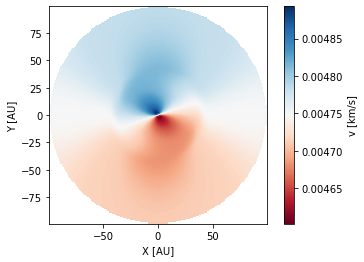

In [131]:
moment = 1
wav0 = lamda_image
vrange = [-1.0, 1.0]
#mmap = im.getMomentMap(moment=1, wav0=wav0)
mmap = im.plotMomentMap(moment=1, wav0=wav0, dpc=dpc, au=True, cmap='RdBu', vclip=vrange)

In [132]:
import bettermoments as bm
data, velax = bm.load_cube(fname)
rms = bm.estimate_RMS(data=data, N=5)
moments = bm.collapse_first(velax=velax, data=data, rms=rms)
bm.save_to_FITS(moments=moments, method='first', path=fname)